# RL homework 2
**Due date: 26nd March 2021, 4:00pm **

Name: ***Alexandra Maria Proca***

Student number: ***20047328***

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<student_id>_ucldm_rl2.ipynb`** before the deadline above.

## Context

In this assignment, we will take a first look at learning algorithms for sequential decision problems.

## Background reading

* Sutton and Barto (2018), Chapters 3 - 6

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [2]:
import matplotlib.collections as mcoll
import matplotlib.path as mpa
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [3]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-colorblind')

### Some grid worlds

In [4]:
W = -100  # wall
G = 100  # goal

GRID_LAYOUT = np.array([
  [W, W, W, W, W, W, W, W, W, W, W, W],
  [W, W, 0, W, W, W, W, W, W, 0, W, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, G, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, W, 0, 0, 0, 0, 0, 0, 0, 0, W, W],
  [W, W, W, W, W, W, W, W, W, W, W, W]
])

class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID_LAYOUT
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    if self._layout[new_y, new_x] == W:  # wall
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = -1.
      discount = 0.9
    else:  # a goal
      discount = 0.
      new_state = self._start_state

    if self._noisy:
      width = self._layout.shape[1]
      reward += 10*np.random.normal(0, width - new_x + new_y)

    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != W, interpolation="nearest", cmap='pink')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(9, 2, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


In [5]:
SMALL_GRID_LAYOUT = np.array([
  [W, W, W, W, W],
  [W, W, 3, W, W],
  [W, W, 0, W, W],
  [W, 1, 0, W, W],
  [W, W, 0, W, W],
  [W, W, 0, 4, W],
  [W, W, W, W, W]
])


def plot_small_grid(version=1):
  plt.imshow(SMALL_GRID_LAYOUT < -1, interpolation='nearest', cmap='pink_r',
             vmin=-0.2, vmax=1.2)
  if version == 1:
    plt.text(2, 1, '$+3$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+4$', ha='center', va='center', fontsize=12)
  else:
    plt.text(2, 1, '$+2$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+5$', ha='center', va='center', fontsize=12)
  plt.text(2, 3, '$S$', ha='center', va='center', fontsize=12)
  h, w = SMALL_GRID_LAYOUT.shape
  for r in np.arange(0.5, h):
    plt.plot([-0.5, w - 0.5], [r, r], '-k', lw=3, alpha=0.4)
  for c in np.arange(0.5, w):
    plt.plot([c, c], [-0.5, h - 0.5], '-k', lw=3, alpha=0.4)
  plt.xticks([]); plt.yticks([]);

### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [6]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += reward
    return mean_reward/float(number_of_steps)

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(grid, values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values - 1000*(grid<0), interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(grid, action_values, vmin=-5, vmax=5):
  q = action_values
  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(4, 3, map_from_action_to_subplot(a))
    plot_values(grid, q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(4, 3, 5)
  v = np.max(q, axis=-1)
  plot_values(grid, v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
  # Plot arrows:
  plt.subplot(4, 3, 11)
  plot_values(grid, grid==0, vmax=1)
  for row in range(len(grid)):
    for col in range(len(grid[0])):
      if grid[row][col] == 0:
        argmax_a = np.argmax(q[row, col])
        if argmax_a == 0:
          x = col
          y = row + 0.5
          dx = 0
          dy = -0.8
        if argmax_a == 1:
          x = col - 0.5
          y = row
          dx = 0.8
          dy = 0
        if argmax_a == 2:
          x = col
          y = row - 0.5
          dx = 0
          dy = 0.8
        if argmax_a == 3:
          x = col + 0.5
          y = row
          dx = -0.8
          dy = 0
        plt.arrow(x, y, dx, dy, width=0.02, head_width=0.4, head_length=0.4, length_includes_head=True, fc='k', ec='k')

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])


def colorline(x, y, z):
    """
    Based on:
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=plt.get_cmap('copper_r'),
                              norm=plt.Normalize(0.0, 1.0), linewidth=3)

    ax = plt.gca()
    ax.add_collection(lc)
    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def plotting_helper_function(_x, _y, title=None, ylabel=None):
  z = np.linspace(0, 0.9, len(_x))**0.7
  colorline(_x, _y, z)
  plt.plot(0, 0, '*', color='#000000', ms=20, alpha=0.7, label='$w^*$')
  plt.plot(1, 1, '.', color='#ee0000', alpha=0.7, ms=20, label='$w_0$')
  min_y, max_y = np.min(_y), np.max(_y)
  min_x, max_x = np.min(_x), np.max(_x)
  min_y, max_y = np.min([0, min_y]), np.max([0, max_y])
  min_x, max_x = np.min([0, min_x]), np.max([0, max_x])
  range_y = max_y - min_y
  range_x = max_x - min_x
  max_range = np.max([range_y, range_x])
  plt.arrow(_x[-3], _y[-3], _x[-1] - _x[-3], _y[-1] - _y[-3], color='k',
            head_width=0.04*max_range, head_length=0.04*max_range,
            head_starts_at_zero=False)
  plt.ylim(min_y - 0.2*range_y, max_y + 0.2*range_y)
  plt.xlim(min_x - 0.2*range_x, max_x + 0.2*range_x)
  ax = plt.gca()
  ax.ticklabel_format(style='plain', useMathText=True)
  plt.legend(loc=2)
  plt.xticks(rotation=12, fontsize=10)
  plt.yticks(rotation=12, fontsize=10)
  plt.locator_params(nbins=3)
  if title is not None:
    plt.title(title, fontsize=20)
  if ylabel is not None:
    plt.ylabel(ylabel, fontsize=20)
  

# Section 1: Tabular RL _(60 pts in total for the whole section)_

In this section, observations will be states in the environment, so the agent state, environment state, and observation will all be the same, and we will use the word `state` interchangably with `observation`.  You will implement agents, which should be in pure Python - so you cannot use JAX/TensorFlow/PyTorch to compute gradients. Using `numpy` is fine.

## Q1: A small grid world _(10 pts in total)_

Consider the grid MDP below:

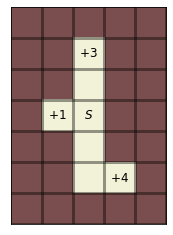

In [7]:
plot_small_grid()

The agent starts at the state marked $S$, and  can move up, left, right, or down.  Whenever it enters a cell with a positive number, the agent receives that reward and the episode terminates.
### Q1.1 [**3 pts**]
Use the code below to plot the value of the optimal policy from the starting state, $v_*(S)$, as a function of the discount factor $\gamma$.

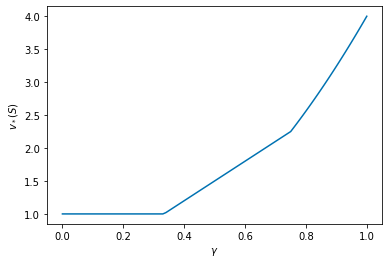

In [28]:
def v(discount):
    return max(1, 3*discount, 4*discount**2)

# Don't change this function
def plot_v():
  discounts = np.arange(0, 1.001, 0.01)
  plt.plot(discounts, [v(g) for g in discounts])
  plt.xlabel('$\gamma$')
  plt.ylabel('$v_*(S)$')

plot_v()

### Q1.2 [**2 pts**]

Specify the optimal policy, as a function of $\gamma$.

### Answer

The 3 shortest-path policies to rewards are defined as: <br/>
policy $\pi_1$: {Left} ; $v_1(S) = R_1 = 1$ <br/>
policy $\pi_2$: {Up, Up} ; $v_2(S) = R_1 + \gamma (R_2) = 0 + 3 \gamma = 3 \gamma$ <br/>
policy $\pi_3$: {Down, Down, Right} ; $v_3(S) = R_1 + \gamma (R_2 + \gamma (R_3)) = 0 + \gamma (0 + 4 \gamma) = 4 \gamma ^2$<br/>
The optimal policy can be written in terms of the discounted return of each policy;  the optimal policy is the policy which yields the maximum reward for a given value of $\gamma$. Specifically, <br/>
$\pi^*(\gamma) = \arg \max_\pi v_{\pi}(S)$ <br/>
$= \arg \max_\pi \{v_1(S), v_2(S), v_3(S)\}$ <br/>
$= \arg \max_\pi \{1 , 3 \gamma, 4 \gamma ^2 \} $ <br/>
where each $v_{\pi}(S)$ corresponds to the policy yielding the return as specified above.

### Q1.3 [**2 pts**]
Consider the variation of this problem shown in the next plot.

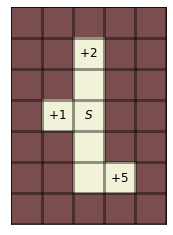

In [9]:
plot_small_grid(version=2)

Suppose a behavioural scientist was doing an experiment where they gave rewards to an animal.  Suppose the setting was as depicted above, where the rewards for instance correspond to food or some other kind of treat (e.g., 5 food pellets at the location marked $+5$). It turns out that, after repeatedly exploring the grid, the animal seems to prefer going up to the reward of $+2$.

Prove that in the MDP depicted above no scalar discount $\gamma \in [0, 1]$ exists for which the optimal policy is to go to $+2$.

### Answer

The optimal policy for the MDP depicted above can be written in terms of the three policies yielding the shortest path to each reward. Specifically, <br/>
policy $\pi_1$ = {Left} ; $v_1(S)=R_1 = 1$ <br/>
policy $\pi_2$ = {Up, Up} ; $v_2(S)=R_1 + \gamma (R_2) = 0 + \gamma (2) = 2\gamma$<br/>
policy $\pi_3$ = {Down, Down, Right} ; $v_3(S) = R_1 + \gamma (R_2 + \gamma (R_3) ) = 0 + \gamma (0 + \gamma (5)) = 5\gamma ^2$ <br/>
Thus, the optimal policy written in terms of the discount is <br/>
$\pi^* (\gamma) = \arg \max_\pi \{v_1(S), v_2(S), v_3(S)\} $ <br/>
$ = \arg \max_\pi \{1, 2\gamma, 5\gamma ^2\}$ <br/> <br/>

In order for the optimal policy to go to +2 (for which the shortest path is policy $\pi_2$), <br/>
$v_2(S) > v_1(S)$ and $v_2(S) > v_1(S)$ <br/>
$2\gamma > 1 ; 2\gamma > 5 \gamma ^2$ for some value $\gamma \in [0,1]$. <br/> <br/>

Solving for $\gamma$ where $v_2(S) > v_1(S)$, <br/>
$2\gamma > 1$ <br/>
$\gamma > \frac{1}{2}$. <br/>
Thus, for $\gamma > \frac{1}{2}$, $v_2(S) > v_1(S)$ <br/> <br/>

Similarly, solving for $\gamma$ where $v_2(S) > v_3(S)$, <br/>
$2\gamma > 5 \gamma ^2$ <br/>
$\gamma < \frac{2}{5}$. <br/>
Thus, for $\gamma < \frac{2}{5}$, $v_2(S) > v_3(S)$ <br/> <br/>

From $\gamma \in [0, \frac{2}{5}]$, $v_2(S) > v_3(S)$ and from $\gamma \in [\frac{1}{2}, 1]$, $v_2(S) > v_1(S)$. Thus, there are no intersecting values of $\gamma \in [0,1]$ for which $v_2(S) > v_1(S)$ and $v_2(S) > v_3(S)$. This means that the value of at least one other policy is greater than policy $\pi_2$ for all values of $\gamma \in [0,1]$. Thus, policy $\pi_2$ will never yield the maximum return and therefore never be the optimal policy for the given MDP.

### Q1.4 [**3 pts**]
In the same setting as the previous question, now consider the following generalised definition of a Monte Carlo return
\begin{align*}
G_t
& = R_{t+1} + f(R_{t+1} + f(R_{t+2} + f(\ldots))) \\
& = R_{t+1} + f(G_{t+1}) \,,
\end{align*}
In this formulation, we get standard discounting when we define $f(x) = \gamma x$. Consider the following alternative where instead of multiplying with a factor $\gamma$, we raise the value to the power: $f(x) = x^\gamma$.  Does this mathematical model better explain the observed behaviour, in the sense that a $\gamma$ exists for which the optimal policy goes to $+2$?  If so, give such a value for $\gamma$, and prove that the policy of going to $+2$ is optimal with that choice.  If not, prove that no such $\gamma$ exists.


### Answer
The discounted returns for each shortest-path policy under the new model are now defined as: <br/>
policy $\pi_1$ = {Left} ; $v_1(S)=R_1 = 1 $ <br/>
policy $\pi_2$ = {Up, Up} ; $v_2(S)=R_1 + (R_2)^\gamma = 0+(2)^\gamma = 2^{\gamma}$ <br/>
policy $\pi_3$ = {Down, Down, Right} ; $v_3(S)=R_1 + (R_2+(R_3)^\gamma )^\gamma = 0+(0+(5)^\gamma) ^\gamma = 5^{\gamma ^2} $ <br/>
Thus, the optimal policy written in terms of the discount is <br/>
$\pi^* (\gamma) = \arg \max_\pi \{v_1(S), v_2(S), v_3(S)\} $ <br/>
$ = \arg \max_\pi \{1, 2^\gamma, 5^{\gamma ^2}\}$ <br/> <br/>

In order for the optimal policy to go to +2 (for which the shortest path is policy $\pi_2$) for some discount factor $\gamma \in [0,1]$, <br/>
$v_2(S) > v_1(S)$ and $v_2(S) > v_3(S)$ <br/>
$2^\gamma > 1$, $2^ \gamma > 5^{ \gamma ^2}$ <br/> <br/>

Solving for $\gamma$ where $v_2(S) > v_1(S)$, <br/>
$2^\gamma > 1$ <br/>
$\gamma \log 2 > \log 1$ <br/>
$\gamma \log 2 > 0$ <br/>
$\gamma > 0$ <br/>
Thus, for $\gamma > 0$, $v_2(S) > v_1(S)$ <br/> <br/>

Similarly, solving for $\gamma$ where $v_2(S) > v_3(S)$, <br/>
$2^\gamma > 5 ^ {\gamma ^2}$ <br/>
$\gamma \log 2 > \gamma ^2 \log 5$ <br/>
$\gamma < \frac{\log 2}{\log 5}$ <br/>
Thus, for $\gamma < \frac{\log2}{\log5} $, $v_2(S) > v_3(S)$ <br/> <br/>

$v_2(S) > v_1(S)$ and $v_2(S) > v_3(S)$ occur at intersecting values of $\gamma \in [0, \frac{\log 2}{\log 5}]$. Therefore, the mathematical model does explain the observed behavior for values of $\gamma \in [0, \frac{\log 2}{\log 5}]$ as the discounted return of policy $\pi_2$, $v_2(S)$, is the largest value of the three shortest-path policies, yielding an optimal policy $\pi^*=\pi_2$. Thus, under this model, the policy of going to +2 is optimal for $\gamma \in [0, \frac{\log 2}{\log 5}]$.

# Implementing algorithms

**Minimal agent interface**:

Each agent should implement the following methods:

### `__init__(self, number_of_actions, number_of_states, initial_observation, ...)`:
The constructor will provide the agent the number of actions, number of states, and the initial state. You can get the initial state by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`. The constructor may accept additional arguments (denoted here by the ellipsis `...`) depending on the specific algorithm implemented by the agent.

### `step(self, reward, discount, next_state)`:

The step method of an agent should update its internals, in whatever way is appropriate for its learning algorithm, and return a new action to be executed in the environment.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_state` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_state})$" in the update, because $\gamma = 0$ (for whatever definition of $v$ is appropriate---for instance, $v(s)$ could be defined in terms of action values estimates that we are learning, for instance by $v(s) = \max_a q(s, a)$).  Therefore, the end of an episode can be seamlessly handled with the same step function.

**Note on the initial action**:

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state and reward.  In the constructor (`__init__`), make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```
In our experiments the helper functions above will execute the action `0` (which corresponds to `up` in the grid world) as the initial action to begin the run loop of the experiment.  This initial action is only executed once, and the beginning of the very first episode---not at the beginning of each episode.

### A random agent

Below we show a reference implementation of a simple random agent, implemented according to the interface above.

In [10]:
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(self._number_of_actions)
    return next_action

### The grid

The cell below shows the `Grid` environment that we will use in this section. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-100` for bumping into a wall, `+100` for reaching the goal, and `-1` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

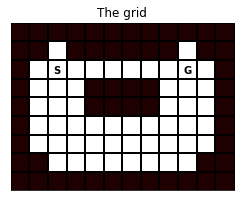

In [11]:
grid = Grid()
grid.plot_grid()


## Q2: Implement TD learning **[5 pts]**
Implement an agent that acts randomly, and _on-policy_ estimates state values $v(s)$, using one-step TD learning with step size $\alpha=0.1$.

In addition to the base interface, also implement a property `state_values(self)` returning the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  

**Hint**: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.


In [12]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  @property
  def state_values(self):
    return self._values

  def step(self, reward, discount, next_state):
    self._values[self._state] += self._step_size*(reward + discount*self._values[next_state]-self._values[self._state])
    self._state = next_state
    action = np.random.randint(self._number_of_actions)
    return action

### Run the next cell to run the `RandomTD` agent on a grid world.

If everything worked as expected, the plot below will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange below).

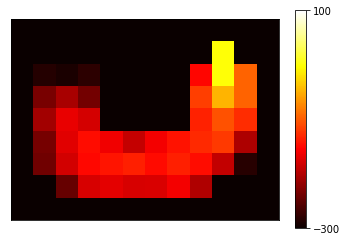

In [13]:
# Do not modify this cell.
agent = RandomTD(grid._layout.size, 4, grid.get_obs())
run_experiment(grid, agent, int(1e5))
v = agent.state_values
plot_values(GRID_LAYOUT, v.reshape(grid._layout.shape), colormap="hot", vmin=-300, vmax=100)

## Q3: Policy iteration **[5 pts]**
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model, so for each state and for each action we can look at the value of the resulting state, and would then pick the action with the highest reward plus subsequent state value. In other words, you can assume we can use $q(s, a) = \mathbb{E}[ R_{t+1} + \gamma v(S_{t+1}) \mid S_t = s, A_t = a]$, where $v$ is the value function learned by TD as implemented. Then we consider the policy that picks the action with the highest action value $q(s, a)$. You do **not** have to implement this, just answer the following question.

The above amounts to performing an iteration of policy evaluation and policy improvement.  If we repeat this process over and over again, and repeatedly evaluate the greedy policy and then perform an improvement step by picking the greedy policy, would the policy eventually become optimal?  Explain why or why not in at most three sentences.

> The policy would not be guaranteed to eventually become optimal, assuming that in this setting, random TD (as implemented above) is learning the value function $v$ until convergence and then performing policy improvement, by taking the greedy policy with respect to a one-step look-ahead based on the learned values $v$. This algorithm would choose and update towards the greedy policy at each time-step. Since the value function learned by random TD is biased towards the longer, safer path, this method would only act upon this route and would not explore due to the property of greediness. The algorithm would continue to exploit this path, without exploring others, yielding a positive return and converging, but not to the optimal shortest path at the top of the grid. Thus, the greedy policy would not eventually become optimal.


## Q4: Implement a general Q-learning agent **[15 pts]**
Implement a  **general Q-learning** agent that learns action values from experience.   The agent must act according to an $\epsilon$-greedy policy over its action values.  It must be configurable so as to implement any of **Sarsa**, **Expected Sarsa**, **Q-learning**,  and **double Q-learning**.

The `__init__` must accept two functions `target_policy` and `behaviour_policy` as arguments.   The function `behaviour_policy(action_values)` should map `action_values` to a single action. 

For instance, the random policy can be implemented as:
```
def behaviour_policy(action_values):
  return np.random.randint(len(action_values))
```

The target policy is defined by a function `target_policy(action_values, action)`, which returns **a vector** with one probability per action.  The `action` argument is used for instance by Sarsa (where the target policy is a greedy distribution with its peak on the selected action).

For instance, the random target policy is:
```
def target_policy(action_values, unused_action):
  number_of_actions = len(action_values)
  return np.ones((number_of_actions,))/number_of_actions
```

The `__init__` must also accept  a `double` boolean flag. Note that this is compatible with any choice of `target_policy` and `behaviour_policy`. For instance, if the `target_policy` is the policy described above for Sarsa and `double=True`, the algorithm should implement **double Sarsa**. Note that we then need two action-value functions.

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the update on the first transition in the agent's lifetime.  


In [14]:
class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state,
               target_policy, behaviour_policy, double, step_size=0.1):
    # Settings.
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    # Initial state.
    self._s = initial_state
    # Tabular q-estimates.
    self._q = np.zeros((number_of_states, number_of_actions))
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
    # The first action in an agent's lifetime is always 0(=up) in our setup.
    self._last_action = 0

  @property
  def q_values(self):
    return (self._q + self._q2)/2 if self._double else self._q

  def step(self, reward, discount, next_state):
    action = self._behaviour_policy(self.q_values[next_state])
    if self._double:
        if np.random.random() < 0.5:
            self._q[self._s][self._last_action] += self._step_size * (reward + discount*np.dot(self._q2[next_state], self._target_policy(self._q[next_state], action)) - self._q[self._s][self._last_action])
        else:
            self._q2[self._s][self._last_action] += self._step_size * (reward + discount*np.dot(self._q[next_state], self._target_policy(self._q2[next_state], action)) - self._q2[self._s][self._last_action])
    else:
        self._q[self._s][self._last_action] += self._step_size*(reward + discount*np.dot(self._q[next_state], self._target_policy(self._q[next_state], action))-self._q[self._s][self._last_action])

    self._last_action = action
    self._s = next_state
    return action  

## Experiment 1: Run the cells below

This will train Q-learning, Sarsa, Expected Sarsa, and double Q-learning agents on the deterministic version of the Grid problem.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [15]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

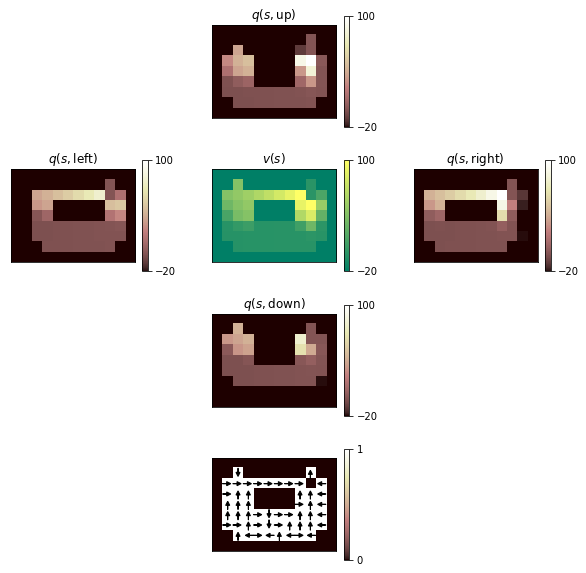

In [16]:
# Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

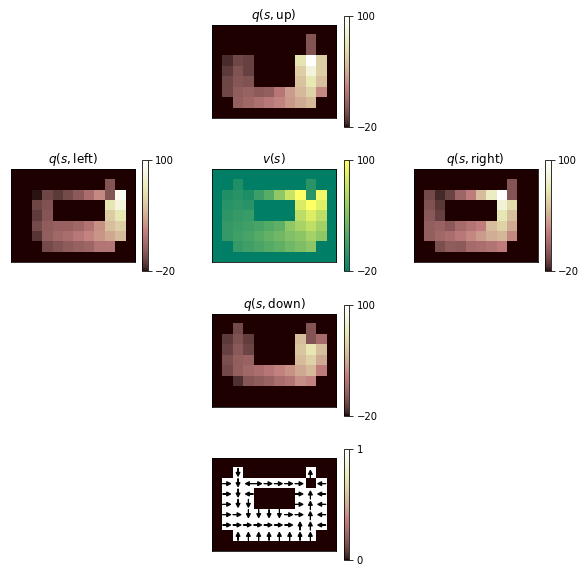

In [17]:
# Sarsa
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[a]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

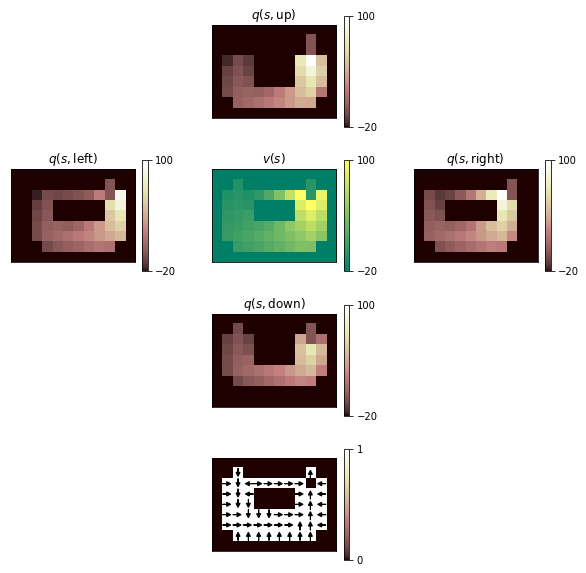

In [18]:
# Expected Sarsa
# Do not modify this cell.
grid = Grid()
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  greedy = np.eye(len(q))[np.argmax(q)]
  return greedy - greedy*epsilon + epsilon/4 

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

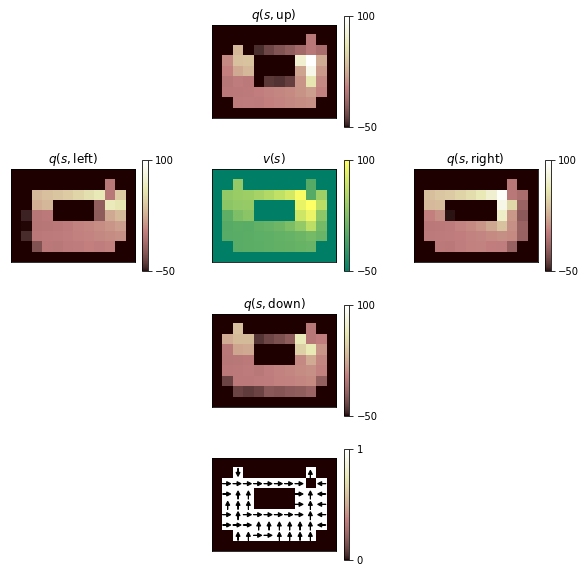

In [34]:
# Double Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  # Place equal probability on all actions that achieve the `max` value.
  # This is equivalent to `return np.eye(len(q))[np.argmax(q)]` for Q-learning
  # But results in slightly lower variance updates for double Q.
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=True, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-50, vmax=100)

## Q5: Analyse results _(10 pts in total)_

Consider the greedy policy with respect to the estimated values learned by each of the four agents.

**[5 pts]** How and why do the policies found by Q-learning, Sarsa, Expected Sarsa, and double Q-learning differ? Explain notable qualitative differences in at most four sentences.

> Notable qualitative differences include that in Q-learning and double Q-learning there is a stronger preference (i.e. high relative state values) for states in the shortest path as opposed to Sarsa and Expected Sarsa which are more evenly split between top and bottom paths of the grid. This is due to the fact that Q-learning is off-policy, updating and acting upon a greedy policy at each step, and thus will always choose the shortest path, despite the fact that epsilon still forces exploration and will cause the agent to take suboptimal steps resulting in a large penalty (-100) when it bumps into a wall. <br/> 
Observing the action values in each state, both Q-learning and double Q-learning take the shortest path (via cliff-walking) whereas Sarsa and Expected Sarsa are more conservative and take the longer route with a greater path width. This is due to the fact that Sarsa and Expected Sarsa account for the behavior policy, unlike Q-learning which does not; thus, Sarsa and Expected Sarsa avoid the cliff-walking path because they optimize the behavior policy and avoid 'high-risk' states (given their added stochasticity acting under epsilon-greedy which may cause them to bump into a wall). Instead, Sarsa and Expected Sarsa prefer to take a safer, albeit longer, route, avoiding walking next to walls. <br/>
Alternatively, Q-learning uses the same approximate values to select and evaluate, operating on a greedy policy, causing it to be biased towards higher action values and against lower action values, consequently finding the shortest path and neglecting other paths (as shown by the very high state values on the shortest path and very low state values of the longer path). Double Q-learning yields a similar optimal policy to Q-learning, but has state values that are more even across the gridworld (not as upwardly biased as Q-learning). This is due to the fact that double Q-learning avoids the maximization bias of Q-learning by decoupling the selection and evaluation of action values through the use of two Q values; therefore, double Q-learning still learns a greedy policy, but it avoids the biased evaluation of standard Q-learning. Finally, because Q-learning is so upwardly biased towards the greedy top path, it fails to learn a good policy for the lower part of the grid as it does not end up exploring the area sufficiently, explaining the seeming randomness of action values.

**[5 pts]** Which of the algorithms, out of Q-learning, Sarsa, Expected Sarsa, and double Q-learning with the learning parameters (exploration, step size) as discussed above, will *in general* yield higher returns on average during learning?  You are allowed to specify a partial (rather than a full) ordering over the algorithms, but try to be as specfic as you can. Explain your answer in at most four sentences.

> In general, the algorithms will yield higher returns during learning in the following order: Expected Sarsa > Sarsa > Q-learning and Double Q-learning > Q-learning. Expected Sarsa will outperform Sarsa because it is taking an expectation and will account for the stochasticity of epsilon greedy during its Q-value update, yielding more stable Q-values, as opposed to Sarsa which will update its Q-values stochastically based on the behavior using epsilon-greedy (meaning it may update based on random sub-optimal actions). Both Expected Sarsa and Sarsa will outperform Q-learning because they account for the stochasticity of the behavior policy, since they operate on-policy, and thus avoid risks that arise from the use of epsilon-greedy, taking the longer and more conservative path, avoiding walls. Instead, Q-learning operates off-policy and will take the greedy shortest path, making more mistakes and incurring more penalties from wall-bumping (-100), due to the high value of epsilon, during learning. Double Q-learning will also outperform Q-learning because of its use of an additional value function to evaluate the policy, decreasing the overestimation bias towards actions, allowing it to explore more and not get stuck in a local optimum. Q-learning will heavily exploit the first optimum it receives until exploring sufficiently to find other optimums, whereas double Q-learning will decrease this exploitation effect as its Q-values will be less biased and take other paths more as a result. This also will allow double Q-learning to be more robust to the randomness of epsilon, having learned other paths.

## Experiment 2: Run the cells below

This will train Q-learning and double Q-learning agents on the stochastic version of the Grid problem.

In the noisy version, a zero-mean Gaussian is added to all rewards.  

The variance of this noise is higher the further to the left you go, and the further down.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [20]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

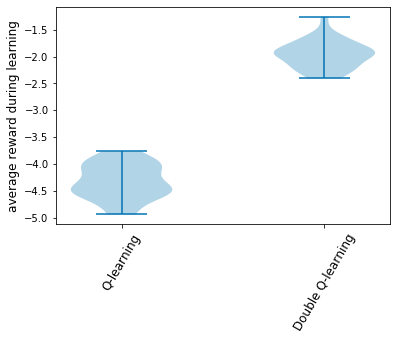

In [21]:
# Q-learning and double Q-learning.
# Do not modify this cell.

def target_policy(q, a):
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)

mean_reward_q_learning = []
mean_reward_double_q_learning = []
for _ in range(30):
  grid = Grid(noisy=True)
  q_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=False, step_size=step_size)
  dq_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=True, step_size=step_size)
  mean_reward_q_learning.append(run_experiment(grid, q_agent, int(2e5)))
  mean_reward_double_q_learning.append(run_experiment(grid, dq_agent, int(2e5)))

plt.violinplot([mean_reward_q_learning, mean_reward_double_q_learning])
plt.xticks([1, 2], ["Q-learning", "Double Q-learning"], rotation=60, size=12)
plt.ylabel("average reward during learning", size=12)
ax = plt.gca()
ax.grid(0)

In [ ]:
# Q-learning and double Q-learning.
# Do not modify this cell.
def expected_sarsa(q, a):
  greedy = np.eye(len(q))[np.argmax(q)]
  return greedy - greedy*epsilon + epsilon/4 

def sarsa(q, a):
  return np.eye(len(q))[a]

def target_policy(q, a):
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)

mean_reward_q_learning = []
mean_reward_double_q_learning = []
mean_reward_sarsa=[]
mean_reward_expected_sarsa=[]
for _ in range(30):
  grid = Grid(noisy=False)
  q_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=False, step_size=step_size)
  dq_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=True, step_size=step_size)
  sarsa_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      sarsa, behaviour_policy, double=False, step_size=step_size)
  expected_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      expected_sarsa, behaviour_policy, double=False, step_size=step_size)

  mean_reward_q_learning.append(run_experiment(grid, q_agent, int(2e5)))
  mean_reward_double_q_learning.append(run_experiment(grid, dq_agent, int(2e5)))
  mean_reward_sarsa.append(run_experiment(grid, sarsa_agent, int(2e5)))
  mean_reward_expected_sarsa.append(run_experiment(grid, expected_agent, int(2e5)))

plt.violinplot([mean_reward_q_learning, mean_reward_double_q_learning, mean_reward_sarsa, mean_reward_expected_sarsa])
plt.xticks([1, 2 , 3, 4], ["Q-learning", "Double Q-learning","SARSA","Expected SARSA"], rotation=60, size=12)
plt.ylabel("average reward during learning", size=12)
ax = plt.gca()
ax.grid(0)

## Q6: Analyse results **[8 pts]**

Which among Q-learning and Double Q-learning has a higher average reward? Explain why, discussing at least a) the dynamics of the algorithm, b) how this affects behaviour, and c) why the behaviour yields higher rewards for one algorithm rather than the other. Be concise.

> Double Q-learning yields a higher average reward. Q-learning performs very poorly in some stochastic environments because the algorithm biases values and thus causes a large overestimation of action values due to the use of the maximum state-action value (the algorithm updates and acts greedily on the same value function). If Q-learning receives a positive reward for a sub-optimal action in the stochastic environment, it may conflate that action and exploit it, even if, on average, it yields a poor comparitive reward. Alternatively, by using a separate value function to evaluate the policy, double Q-learning de-biases this effect- it may underestimate action values at times, but avoids the overestimation/bias that Q-learning does and therefore is more robust to the variance of the environment. This means that in the stochastic environment, double Q-learning will be less affected and will be less likely to get stuck in a minimum as Q-learning might- unbiased estimates will ultimately lead to greater reward as there will be a better model of the environment to operate on.

## Q7: Target Q-learning **[7 pts]**

Consider a new algorithm which we will refer to as **target Q-learning**. The target Q-learning algorithm applies Q-learning updates in the form 
$\ \ q(S_t, A_t) \leftarrow R_{t+1} + \gamma \max_a q'(S_{t+1}, a) \ \ $  
where the values $q'$ have been pre-trained by running $\epsilon$-greedy Expected Sarsa, and are then held fixed throughout training.

We can now imagine now to train both Q-learning and target Q-learning on the deterministic Grid problem.  In both Q-learning and target Q-learning the behaviour policy will select actions based on the same $\epsilon$-greedy policy that was used to pre-train the $q'$ values, but using the current action-value estimates (not the fixed target values $q'$).

Explain concisely which of the two algorithms will perform better and why. (If you're tempted to answer 'it depends', be sure to be clear what you think it depends on, and why. Don't be vague: point could be subtracted for including irrelevant or false statements, even if the correct answer is also given.)

> Target Q-learning will perform better during learning because it's Q-values are fixed: after taking each action at each state once, Target Q-learning's Q-values no longer change because $q(S_t,A_t)\leftarrow R_{t+1}+\gamma \max_a q'(S_{t+1},a)$ will always be the same. Thus, Target Q-learning will essentially act upon the greedy policy of Expected Sarsa Q-values, take the safer route, and avoid penalties (-100) from wall-bumping caused by the randomness epsilon-greedy, leading it to perform better during learning. Alternatively, Q-learning will not perform as well initially because it will not have the advantage of having pretrained Q-values and will first need to explore (and make mistakes) sufficiently in order to learn Q-values and increase its performance. Additionally, even after having learned Q-values, Q-learning will take the greedy shortest path, which is high-risk, and will continue to yield penalties since epsilon will cause it to deviate and bump into walls, while Target Q-learning will take a safer path and avoid this risk. However, after convergence, at test time, when both algorithms only operate on a greedy policy, Q-learning will perform better because it will take the greedy shortest path and not be subject to the perturbations of epsilon causing a penalty, while Target Q-learning will take the longer and safer path (but no longer be at risk of random perturbations of epsiilon) and thus will yield a lower return. Therefore, Target Q-learning will perform better during learning under an epsilon-greedy behavior policy and Q-learning will perform better during testing under a greedy policy.

# Section 2: Off-policy Bellman operators with function approximation
# _(40 pts total for the whole section)_

## Q8: Bellman operator for prediction **[10 pts]**

We are going to implement a Bellman operator for a simple MDP. You should:


1. Write a value function `v(w, x)` that outputs a linear value estimate when we have weights `w` (a numpy vector) and feature vector `x` (a numpy vector of the same size).
2. Write an operator function `T(w, pi, mu, l, g)` that takes weights `w`, a target policy `pi`, a behaviour policy `mu`, a trace parameter `l`, and a discount `g`, and outputs an off-policy-corrected lambda-return.  For this question, implement the standard importance-weighted per-decision lambda-return. There will only be two actions, with the same policy in each state, so we can define `pi` to be a number which is the target probability of selecting action `a` in any state (s.t. `1 - pi` is the probability of selecting `b`), and similarly for the behaviour `mu`.
3. Write an expected weight update, that uses the above two functions to compute the **expected** weight update.  The expectation should take into account the probabilities of actions in the future, as well as the steady-state (=long-term) probability of being in a state.  The step size of the update should be $\alpha=0.1$.

There are two states, $s_1$ and $s_2$.  All rewards are zero, and therefore can be ignored.  The state features $x_1 = x(s_1)$ and $x_2 = x(s_2)$ for the two states are $x_1 = [1, 1]^{\top}$ and $x_2 = [2, 1]^{\top}$.  In each state, there are two actions, $a$ and $b$.  Action $a$ always transitions to state $s_1$, action $b$ always transitions to state $s_2$.

![MDP](https://hadovanhasselt.files.wordpress.com/2020/02/mdp.png)


In [30]:
# state features (do not change)
x1 = np.array([1., 1.])
x2 = np.array([2., 1.])

def v(w, x):
    return w.T @ x
  #pass

def T(w, pi, mu, l, g):
    return lambda x1, x2: (g*(1-l)/(1-g*l))*(pi*v(w,x1)+(1-pi)*v(w,x2))
  #pass

def expected_update(w, pi, mu, l, g, lr): 
    v_pi = T(w, pi, mu, l, g)(x1,x2)
    return mu*(lr*(v_pi - v(w, x1))*x1)+(1-mu)*(lr*(v_pi-v(w, x2))*x2)
  #pass

##Experiment 3: run the cell below
The cell below runs an experiment, across different target policies and trace parameters $\lambda$.

The plots below the cell will show how the weights move within the 2-dimensional weight space, starting from $w_0 = [1, 1]^{\top}$ (shown as red dot).  The optimal solution $w_* = [0, 0]^{\top}$ is also shown (as black star).

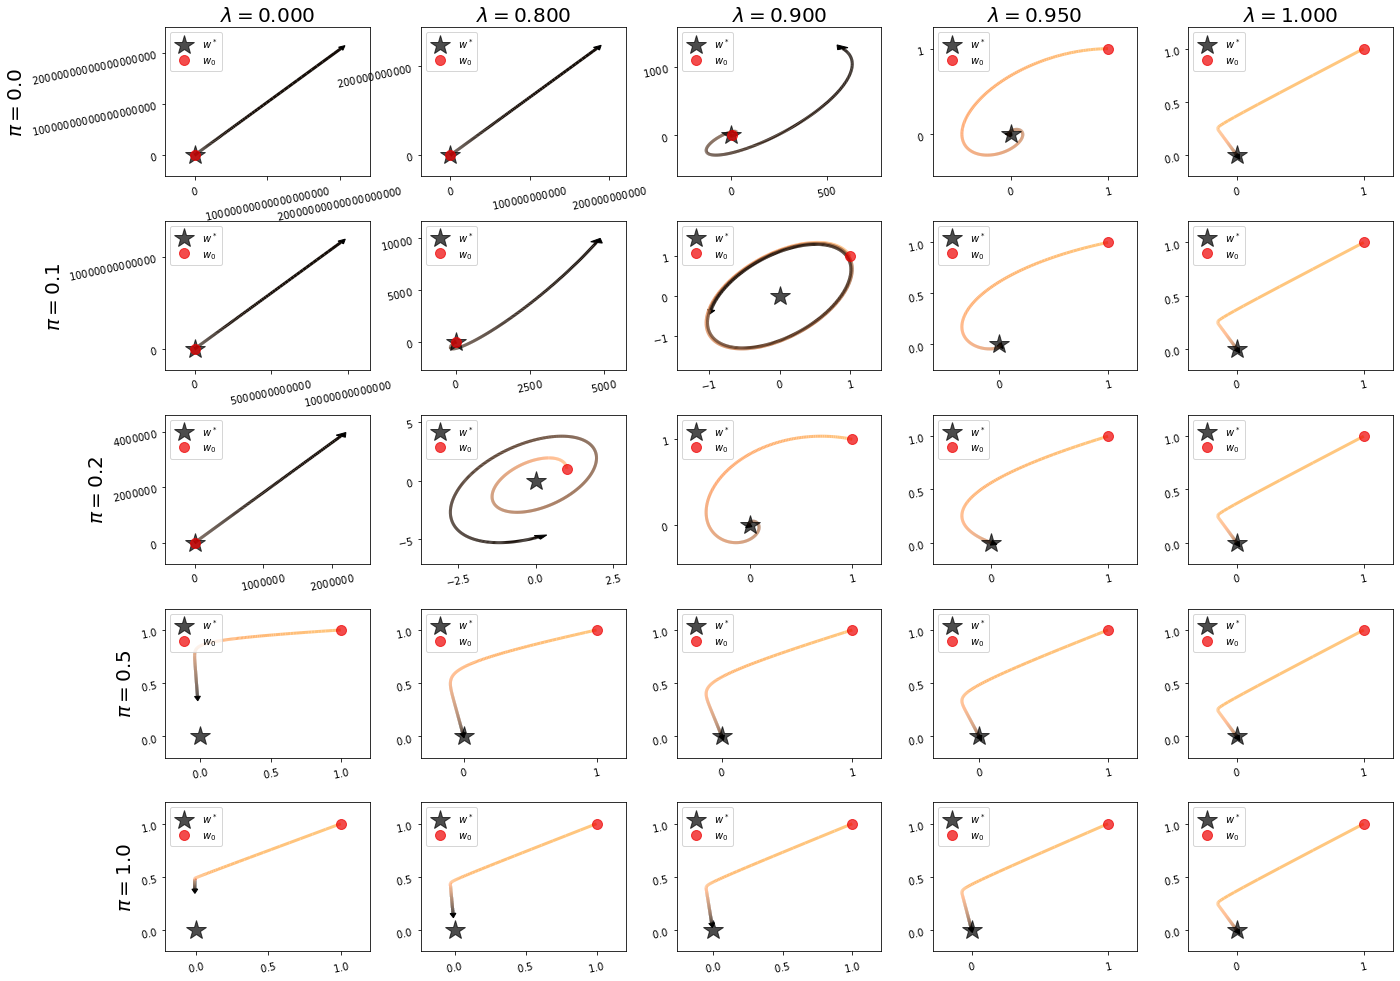

In [31]:
def generate_ws(w, pi, mu, l, g):
  """Apply the expected update 1000 times"""
  ws = [w]
  for _ in range(1000):
    w = w + expected_update(w, pi, mu, l, g, lr=0.1)
    ws.append(w)
  return np.array(ws)

mu = 0.5  # behaviour
g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = generate_ws(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)

## Q9: Analyse results (30 pts total)
1. **[2 pts]** How many of the above 25 experiments diverge?
1. **[4 pts]** Why are the results asymmetric across different $\pi$?  In particular, explain why the results look different when comparing $\pi = \pi(a | \cdot) = 0$ to $\pi(a | \cdot) = 1$.
1. **[4 pts]** For which policies $\pi$, is the true value function $v_{\pi}$ representable in the above feature space (spanned by $x_1, x_2$).
1. **[4 pts]** For which combination of $\pi(a)$ and $\lambda$ does the expected update (with uniform random behaviour) converge? (Do not limit the answer to the subset of values in the plots above, but to all choices of $\lambda$ and $\pi$, but do restrict yourself to state-less policies, as above, for which the action probabilities are equal in the two states.)
1. **[4 pts]** Why do all the plots corresponding to full Monte Carlo look the same?
1. **[4 pts]** Why do the plots corresponding to full Monte Carlo have the shape they do?
1. **[4 pts]** How would the results above change (at high level, not in terms of precise plots) if the behaviour policy $\mu$ would select action $a$ more often (e.g., $\mu = 0.8$)?  How would the results change if the behaviour would select $a$ less often (e.g., $\mu = 0.2$)?
1. **[4 pts]** Consider again the orginal experiment, where data is gathered under uniformly random behaviour policy. What would the updates to the vectors $w$ be under the $L_\infty$ norm? You can either run the experiment or give the closed-form update in an equation.


## Put answers to Q8 in this cell:

For clarity, in the following derivations the used variables will be defined as: <br/>
The state features <br/>
$x(s_1)=[1,1]^T$ <br/>
$x(s_2)=[2,1]^T$ <br/>
The behavior policy value function <br/>
$v_\mu(s_i)=w^Tx(s_i)$ <br/>
The standard importance-weighted per-decision lambda return <br/>
$v_\pi=\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(\pi (v_\mu(s_1))+(1-\pi)v_\mu(s_2))$ <br/>
The expected weight update <br/>
$\Delta w=\alpha[\mu(v_\pi(s)-v_\mu(s_1))x(s_1)+(1-\mu)(v_\pi(s)-v_\mu(s_2))x(s_2)]$ <br/>
1. 7 of the 25 experiments diverge: $\{\pi=0,\lambda=0\}, \{0,0.8\}, \{0,0.9\}, \{0.1,0\},\{0.1,0.8\},\{0.2,0\},\{0.2,0.8\}$ <br/> <br/>
2. The results are asymmetric across different $\pi$ because the state features of $x(s_1)$ and $x(s_2)$ differ asymmetrically (i.e. $[1,1]^T$ vs. $[2,1]^T$). This difference causes the behavior policy value function $v_\mu(s)$ to vary for each state. Thus, each state influences the return asymmetrically as $\pi$ is varied and in turn influences the expected update asymmetrically. Varying $\pi$ from 0 to 1 changes the probability of taking action $a$ and thus also affects the expected return and expected update asymmetrically from $1-\pi$. These differences then yield different behavior in the algorithm, explaining the asymmetric results. Specifically, <br/>
$v_\pi(s)=\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(\pi (v_\mu(s_1))+(1-\pi)v_\mu(s_2))$ <br/>
When $\pi = 0$, <br/>
$v_\pi(s)=\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}v_\mu(s_2)$ <br/>
$=\frac{\gamma-\lambda \gamma}{1-\lambda}w^T[2,1]^T$ <br/>
When $\pi = 1$, <br/>
$v_\pi(s)=\frac{\gamma-\lambda \gamma}{1-\lambda \gamma}v_\mu(s_1)$ <br/>
$=\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}w^T[1,1]^T$ <br/>
Thus, varying $\pi$ will yield asymmetric values for $v_\pi$ and in turn, influence the expected update asymmetrically, causing the results to look different when comparing $\pi=0$ to $\pi=1$, as the expected update is dependent on $v_\pi$. <br/>
$\Delta w=\alpha[\mu(v_\pi(s)-v_\mu(s_1))x(s_1)+(1-\mu)(v_\pi(s)-v_\mu(s_2))x(s_2)]$ <br/> <br/>
3. The true value function $v_\pi=w^Tx_t=0$ is representable in the above feature space (spanned by $x_1,x_2$) for $0<\pi<1$, for which $v_\pi$ exists in the 2D feature space spanned by $x_1$ and $x_2$. Specifically, solving for $w$ at the true value function, <br/>
$E_\pi[(G_t-v_\mu(s_t))x_t]$ <br/>
$=E_\pi[(G_t-x_t^Tw)x_t]$ <br/>
$=E_\pi[G_tx_t-x_tx_t^Tw]=0$ <br/>
$E_\pi[x_tx_t^T]w=E[G_tx_t]$ <br/>
$w=E_\pi[x_tx_t^T]^{-1}E_\pi[G_tx_t]$ <br/>
$w$ only exists when $E_\pi[x_tx_t^T]$ is invertible. Matrices with determinants of 0 are not invertible. Thus, in order to determine for which $\pi$ the true value function does not span the feature space of $x_1, x_2$, we can solve for which values of $\pi$ the determinant is 0 and $w$ does not exist. <br/>
$E_\pi[x_tx_t^T]=\pi x_1x_1^T+(1-\pi)x_2x_2^T$ <br/>
$=\pi[1,1]^T[1,1]+(1-\pi)[2,1]^T[2,1]$ <br/>
$=\pi \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix} + (1-\pi) \begin{bmatrix} 4 & 2 \\ 2 & 1 \end{bmatrix}$ <br/>
$=\begin{bmatrix} \pi & \pi \\ \pi & \pi \end{bmatrix} + \begin{bmatrix} 4-4\pi & 2-2\pi \\ 2-2\pi & 1-\pi \end{bmatrix}$ <br/>
$=\begin{bmatrix} 4-3\pi & 2-\pi \\ 2-\pi & 1 \end{bmatrix}$ <br/>
Taking the determinant and setting to 0, <br/>
$\det(\begin{bmatrix} 4-3\pi & 2-\pi \\ 2-\pi & 1 \end{bmatrix})=0$ <br/>
$=(4-3\pi)(1)-(2-\pi)(2-\pi)$ <br/>
$=4-3\pi-4+4\pi-\pi^2$ <br/>
$=\pi-\pi^2$ <br/>
$=\pi(1-\pi)=0$ <br/>
$\pi = 0,1$ <br/>
Therefore, for $\pi=0,1$, the determinant of $E_\pi[x_tx_t^T]$ is 0, $w$ does not exist, and thus, the true value function $v_\pi=w^Tx_t=0$ is not representable in the feature space spanned by $x_1,x_2$. This means that the true value function $v_\pi$ is only representable in the above feature space for the policies $0<\pi<1$. <br/> <br/>
4. The expected weight update is <br/>
$\Delta w=\alpha[\mu(v_\pi(s)-v_\mu(s_1))x(s_1)+(1-\mu)(v_\pi(s)-v_\mu(s_2))x(s_2)]$ <br/>
which can be further written out in terms of $w=[w_1, w_2]^T$ and $x_1,x_2$ <br/>
$\Delta w=\alpha[\mu(\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(\pi (w_1+w_2)+(1-\pi)(2w_1+w_2))-(w_1+w_2))[1,1]^T+(1-\mu)(\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(\pi (w_1+w_2)+(1-\pi)(2w_1+w_2))-(2w_1+w_2))[2,1]^T]$ <br/>
This can be further simplified to yield a form of $Aw_t$ <br/>
$\Delta w=\alpha \begin{bmatrix} \frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(4-2\pi-2\mu+\mu\pi)+3\mu-4 & \frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(2-\mu)-2+\mu \\ \frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(2-\pi)-2+\mu & \frac{\gamma-\lambda \gamma}{1-\lambda\gamma}-1 \end{bmatrix}\begin{bmatrix} w_1 \\ w_2 \end{bmatrix}$ <br/>
Starting from an initialization of weights $w_0=[1,1]^T$, at time-step $t+1$, we have <br/>
$w_{t+1}=w_t+\Delta w_t = w_t + Aw_t = (I+A)w_t = (I+A)^t w_0$ <br/>
In order for the expected update to converge under a given set {$\pi, \lambda$}, $\lim_{t\rightarrow\infty} w_t=\lim_{t\rightarrow\infty} (I+A)^tw_0=[0,0]^T$. Therefore, in order for the expected weights to decay and converge to 0, the determinant of the update matrix $I+A$ must be less than 1 (i.e., contracting) for given values of $\pi, \lambda$. Thus, substituting $\mu=0.5, \alpha=0.1$ and solving for the determinant, <br/>
$\det(A+I)=(0.1(\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(4-2\pi-1+0.5\pi)-2.5)+1)(0.1(\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}-1)+1) - (0.1(\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(1.5)-1.5)+1)(0.1(\frac{\gamma-\lambda \gamma}{1-\lambda\gamma}(2-\pi)-1.5)+1) < 1$ <br/>
Simplifying and substituting $\gamma=0.99$ yields a final inequality of <br/>
$\pi < 0.95-\frac{2.095-2.07405\lambda}{0.99-0.99\lambda}$ <br/>
Thus, for all values $\pi, \lambda$ satisfying the inequality, given the original initializations, the expected update will converge. <br/> <br/>
5. The plots corresponding to full Monte Carlo (when the discount factor $\lambda$ is set to 1 and all steps are weighted equally) look the same because the entire $v_\pi(s)$ term becomes 0 when $\lambda=1$, so $w$ only updates based on changes in $v_\mu (s)$ and constants ($\mu,\alpha,x(s_1),x(s_2)$), which is the same for all values of $\pi$ since all terms containing $\pi$ are zeroed. Therefore, the influence of $\lambda,\pi$ on weight updates is fixed and does not vary across all plots corresponding to Monte Carlo. Specifically, <br/>
$\Delta w=\alpha[\mu(v_\pi(s)-v_\mu(s_1))x(s_1)+(1-\mu)(v_\pi(s)-v_\mu(s_2))x(s_2)]$ <br/>
$v_\pi(s)=\frac{\gamma-\lambda \gamma}{1-\lambda}(\pi (v_\mu(s_1))+(1-\pi)v_\mu(s_2))$ <br/>
When $\lambda = 1$ (i.e., Monte Carlo): <br/>
$v_\pi(s)=\frac{\gamma-\gamma}{1-1}(\pi (v_\mu(s_1))+(1-\pi)v_\mu(s_2))=0$ <br/>
Thus, <br/>
$\Delta w=\alpha[\mu(0-v_\mu(s_1))x(s_1)+(1-\mu)(0-v_\mu(s_2))x(s_2)]$ <br/>
$=\alpha[-\mu v_\mu(s_1)x(s_1)+(1-\mu)v_\mu(s_2)x(s_2)]$ <br/>
The target policy distribution $\pi$ is eliminated from the weight update when performing Monte Carlo ($\lambda=1$) and thus all the plots corresponding to MC do not depend on the value of $\pi$ (which is varied across plots), thus yielding identical expected weight updates and identical plots (because the initializing values $\mu, \alpha, v_\mu(s), x(s)$ are held constant). <br/> <br/>
6. Using the expected weight update matrix $A$ predefined in 9.4 and substituting $\lambda=1$ for Monte Carlo yields the update, <br/>
$\Delta w_{MC}=\alpha \begin{bmatrix} 3\mu -4 & \mu -2\\ \mu-2 & -1 \end{bmatrix} \begin{bmatrix} w_1\\ w_2 \end{bmatrix}$ <br/>
Substituting $\alpha=0.1$, $\mu=0.5$ as initialized, <br/>
$=0.1 \begin{bmatrix} -2.5 & -1.5\\ -1.5 & -1 \end{bmatrix} \begin{bmatrix} w_1\\ w_2 \end{bmatrix}$ <br/>
As shown by the values in the matrix, the expected weight update is negative and a constant weighting, explaining the negative slope when the weights are positive and linear fashion of the plots. Additionally, the magnitude of updates is larger in the first dimension ($[-0.25w_1-0.15w_2]$) versus the second dimension ($[-0.15w_1 -0.1w_2]$), which further explains the weights decaying on the x-axis at a faster rate than the y-axis in the plots. As $w_1$ becomes negative, since it decays more rapidly than $w_2$, its update sign flips (negative update times negative weight $w_1$) causing the gradient in $w_1$ to become positive (as the magnitude of update multiplied by $w_1$, {$-0.25, -0.15$}, is greater than that multiplied by $w_2$, {$-0.15, -0.1$}, allowing it to overcome the negative weighting of $w_2$). This causes a 90 degree rotation, as shown in the plot, and allows for the gradient to continue updating until finally converging to the optimum at $[0,0]^T$. <br/> <br/>
7. If $\mu$ would select action $a$ more often (e.g. $\mu=0.8$), the results would yield more of the plots showing weights that diverge for more (low) values of $\pi$ and $\lambda$. A higher value of $\mu$ increases the weight of the first term and decreases the weight of the second in the weight update: <br/>
$\Delta w=\alpha[\mu(v_\pi(s)-v_\mu(s_1))x(s_1)+(1-\mu)(v_\pi(s)-v_\mu(s_2))x(s_2)]$ <br/> 
$v_\pi(s)=\frac{\gamma-\lambda \gamma}{1-\lambda}(\pi (v(s_1))+(1-\pi)v(s_2))$ <br/>
As $\lambda, \pi \rightarrow 0$, $v_\pi(s)\rightarrow v_\mu(s_2) > v_\mu(s_1)$. <br/>
$v_\pi(s)$ represents an intermediate value between $v_\mu(s_1)$ and $v_\mu(s_2)$, weighted towards $v(s_2)$ by $(1-\pi)$ and downweighted by increasing values of $\lambda$. 
In the expected weight update, the first term including $v_\pi(s)-v_\mu(s_1)$ is positive and its magnitude increases as $\lambda, \pi \rightarrow 0$ because $v_\pi(s)\rightarrow v_\mu(s_2)$; this due to the fact that $v_\mu(s_2)$ is higher in magnitude than $v_\mu(s_1)$ (having state features $[2,1]^T$ vs. $[1,1]^T$). Alternatively, the second term in the expected weight update including $v_\pi(s)-v_\mu(s_2)$ is negative and its magnitude decreases as $\lambda, \pi \rightarrow 0$ because $v_\pi(s)\rightarrow v_\mu(s_2)$ and $v_\pi(s) < v_\mu(s_2)$. Thus, $\mu$ plays an important role in balancing the magnitude of the positive and negative terms in the expected weight update. As $\mu$ increases, the positive first term's magnitude is increased and the negative second term's magnitude is decreased. Thus, if $\mu$ would select action $a$ more often, the positive term would overpower the negative term for more values of $\lambda, \pi$, causing the gradient to be positive, weights to continuously increase, and more plots to diverge. <br/> <br/>
Alternatively, if the behavior policy would select action $a$ less often, the opposite effect would be true and the magnitude of the negative second term's weight would be increased, thus yielding a negative gradient for more values of $\lambda, \pi$, decreasing $w$ to the optimum over time ($\Delta w \rightarrow 0$, $w \rightarrow [0,0]^T$), ensuring that $w$ converges for even lower values of $\pi, \lambda$, being balanced out by the second term. <br/> <br/>
8. The loss of the algorithm under the $L_\infty$ norm can be written as <br/>
$J(w)=\|v_\pi(s)-v_\mu(s)\|=\max_i |v_\pi(s)-v_\mu(s_i)|$ <br/>
Thus, taking the gradient with respect to $w$, <br/>
$\nabla_w J(w)=\frac{\partial (\max_i |v_\pi(s)-v_\mu(s_i)|)}{\partial (v_\pi(s)-v_\mu(s_i))} \frac{\partial(v_\pi(s)-v_\mu(s_i))}{\partial w}$ <br/>
$=\text{sign} (v_\pi(s)-v_\mu(s_i))(-x(s_i))$ <br/>
for $\arg \max_i |v_\pi(s)-v_\mu(s_i)|, i \in [1,2]$ <br/>
Thus, the expected weight update under the $L_\infty$ norm can be written <br/>
$\Delta w= -\alpha \nabla_w J(w)
=\begin{cases}
\alpha \ \text{sign} (v_\pi(s)-v_\mu(s_1))x(s_1) \quad  |v_\pi(s)-v_\mu(s_1)| > |v_\pi(s)-v_\mu(s_2)|  \\
\alpha \ \text{sign} (v_\pi(s)-v_\mu(s_2))x(s_2) \quad  |v_\pi(s)-v_\mu(s_2)| > |v_\pi(s)-v_\mu(s_1)|
\end{cases}$ <br/>
Running the experiment with the weight updates under the $L_\infty$ norm yields the following

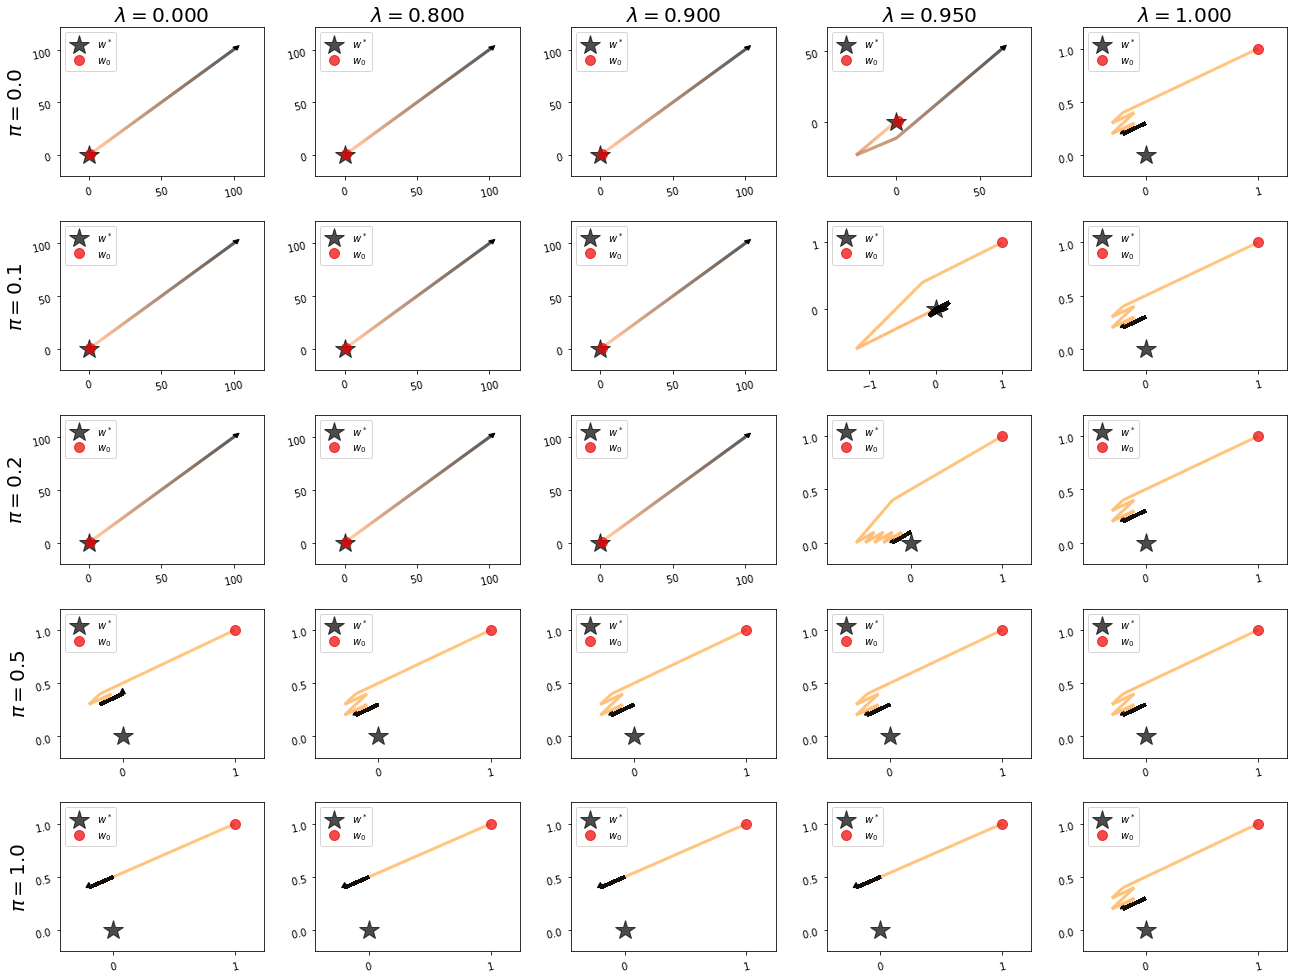

In [32]:
def expected_update_L_infty(w, pi, mu, l, g, lr):
    v_pi = T(w, pi, mu, l, g)(x1,x2)
    if np.abs(v_pi-v(w,x1)) > np.abs(v_pi-v(w,x2)):
        grad_w = lr*np.sign(v_pi-v(w,x1))*x1
    else:
        grad_w = lr*np.sign(v_pi-v(w,x2))*x2
    return grad_w

def generate_ws_L_infty(w, pi, mu, l, g):
  """Apply the expected update 1000 times"""
  ws = [w]
  for _ in range(1000):
    w = w + expected_update_L_infty(w, pi, mu, l, g, lr=0.1)
    ws.append(w)
  return np.array(ws)

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = generate_ws_L_infty(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)